<a href="https://colab.research.google.com/github/pejmanrasti/NLP/blob/main/3_MLP_surname_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron (MLP) for Surname Nationality Classification

This notebook demonstrates how to build and train a Multi-Layer Perceptron (MLP) to classify surnames based on their nationalities using a dataset of surnames and corresponding nationalities.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

## Step 2: Load and Preprocess the Data

The dataset is loaded into a Pandas DataFrame. We need to preprocess this data for our neural network.

In [2]:
# Load the dataset
file_path = 'surnames.csv'
surnames_data = pd.read_csv(file_path)

# Display the first few rows
surnames_data.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


### Data Preprocessing

We need to encode the surnames and nationalities into a numerical format. For surnames, we'll convert each character to its ASCII value. For nationalities, we use label encoding.

In [3]:

# Creating a character set and mapping characters to integers
characters = sorted(list(set(''.join(surnames_data['surname']))))
char_to_int = dict((c, i) for i, c in enumerate(characters))

# Function to convert surname to a sequence of integers
def surname_to_int_array(surname):
    return [char_to_int[char] for char in surname if char in char_to_int]

# Convert surnames to sequences of integers
surnames_data['surname_seq'] = surnames_data['surname'].apply(surname_to_int_array)

# Find the length of the longest surname
max_surname_length = max(surnames_data['surname_seq'].apply(len))

# Pad the sequences so that they are all the same length
from keras.preprocessing.sequence import pad_sequences
surnames_data['surname_padded'] = list(pad_sequences(surnames_data['surname_seq'], maxlen=max_surname_length, padding='post'))

# Convert the padded sequences and labels to numpy arrays for training
X = np.array(surnames_data['surname_padded'].tolist())


In [4]:
# Label encode nationalities
label_encoder = LabelEncoder()
surnames_data['nationality_encoded'] = label_encoder.fit_transform(surnames_data['nationality'])

In [5]:
# One-hot encode the nationality labels
y = to_categorical(surnames_data['nationality_encoded'])

## Step 3: Split the Data

We split the data into training, validation, and test sets.

In [6]:

# Stratified Split of the Data
# We use stratified split to ensure representation of each nationality in all datasets

from sklearn.model_selection import StratifiedShuffleSplit

# Creating a StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Splitting the data - this will only do one split due to n_splits=1
for train_index, temp_index in strat_split.split(X, surnames_data['nationality_encoded']):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Further split X_temp and y_temp into validation and test sets
strat_split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in strat_split_val_test.split(X_temp, y_temp.argmax(axis=1)):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


## Step 4: Build the MLP Model

We build a simple MLP model using Keras.

In [7]:
# Update the MLP model to include an Embedding layer
from keras.layers import Embedding

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(characters), output_dim=50, input_length=max_surname_length))
model.add(Flatten())  # Flatten the output of the embedding layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 50)            4200      
                                                                 
 flatten (Flatten)           (None, 850)               0         
                                                                 
 dense (Dense)               (None, 128)               108928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 18)                1170      
                                                                 
Total params: 122554 (478.73 KB)
Trainable params: 12255

## Step 5: Train the Model

We train the model using the training set and validate it on the validation set.

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
241/241 [==============================] - 7s 17ms/step - loss: 2.0684 - accuracy: 0.3964 - val_loss: 1.7000 - val_accuracy: 0.5203
Epoch 2/50
241/241 [==============================] - 5s 20ms/step - loss: 1.5956 - accuracy: 0.5522 - val_loss: 1.4819 - val_accuracy: 0.5701
Epoch 3/50
241/241 [==============================] - 4s 16ms/step - loss: 1.3914 - accuracy: 0.6011 - val_loss: 1.2937 - val_accuracy: 0.6193
Epoch 4/50
241/241 [==============================] - 2s 7ms/step - loss: 1.2441 - accuracy: 0.6353 - val_loss: 1.2131 - val_accuracy: 0.6472
Epoch 5/50
241/241 [==============================] - 2s 6ms/step - loss: 1.1511 - accuracy: 0.6655 - val_loss: 1.1364 - val_accuracy: 0.6576
Epoch 6/50
241/241 [==============================] - 1s 6ms/step - loss: 1.0679 - accuracy: 0.6853 - val_loss: 1.0832 - val_accuracy: 0.6758
Epoch 7/50
241/241 [==============================] - 2s 7ms/step - loss: 1.0317 - accuracy: 0.6944 - val_loss: 1.0488 - val_accuracy: 0.6934
Epo

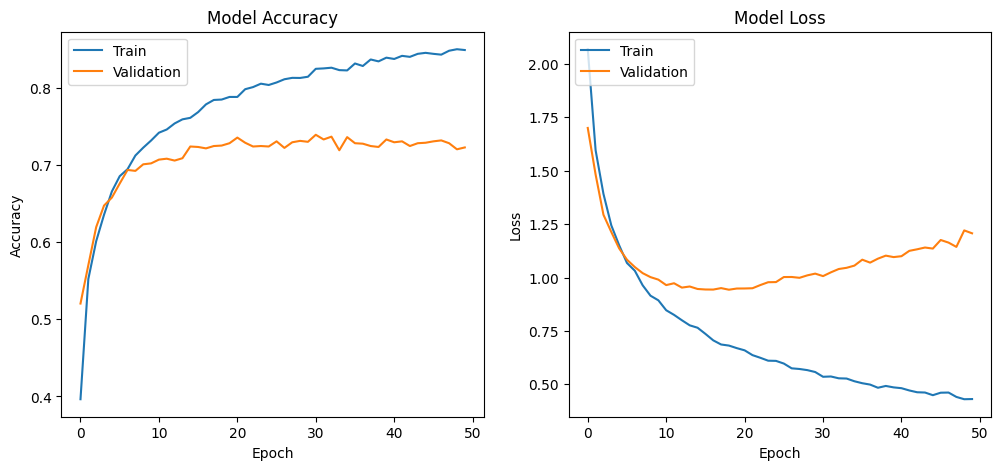

In [11]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Step 6: Evaluate the Model

Evaluate the model's performance on the test set.

In [9]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

52/52 [==============================] - 1s 15ms/step - loss: 1.1601 - accuracy: 0.7341
Test Accuracy: 73.41%


## Step 7: Save the Model (Optional)

Optionally, we can save the model for future use.

In [10]:
# Save the model
model.save('surname_nationality_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TODO: Give a surname to the model and ask the model to predict the nationality of it.

TODO: change the architecture of the model to reduce the overfitting